# AGUA : Automated Genotyping using Unsupervised Algorithm 
## training pipeline Python script
### Diego Frias, 08.10.2023

In [1]:
#import our three important packages
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import sys
import Bio as Bio
from Bio import SeqIO
from Bio import AlignIO

import time as time
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import pandas as pd
import random

import dill # for model object handling

# FASE 1 - PREPROCESSAMENTO
## LEITURA DO DATASET DE TREINAMENTO & IDENTIFICAÇÃO/CODIFICAÇÃO DE CLASSES PRIMÁRIAS

In [2]:
base = [16, 4, 1]

nucleotides = {
"A": 0,
"G": 1,
"C": 2,
"T": 3,
"a": 0,
"g": 1,
"c": 2,
"t": 3,
}

stops=["TAA","TAG","TGA"]

stopnmb=[]

for triplet in stops:
    codonNumber = 0 # 0 to 63
    for p in range(3):
          codonNumber += base[p] * nucleotides[triplet[p]]
    stopnmb.append(codonNumber)

print("stop codon ordinals ",stopnmb)

stop codon ordinals  [48, 49, 52]


In [3]:
#import the sequences we will use. These are 16s sequences from GenBank
#example: https://www.ncbi.nlm.nih.gov/nuccore/FJ039971.1?report=genbank
fname = "/home/m_souza/tcc/dataset/dataset_agua/sequencias_treinamento.fasta"
# fname = "spike_alingment.fas"
# t1 = SeqIO.read("sequence1.fasta", "fasta")
# t2 = SeqIO.read("sequence2.fasta", "fasta")
# t3 = SeqIO.read("sequence3.fasta", "fasta")
# t4 = SeqIO.read("sequence4.fasta", "fasta")
# t5 = SeqIO.read("sequence5.fasta", "fasta")
# t6 = SeqIO.read("sequence6.fasta", "fasta")
# t7 = SeqIO.read("sequence7.fasta", "fasta")

t=[]
with open(fname) as handle:
    for values in SeqIO.FastaIO.SimpleFastaParser(handle):
        t.append(values)
        print(t[-1][0])

Nseq=len(t)

print("number of sequences in file ",fname," = ",Nseq)

spike(pos.ini:21562 pos.fin:25384)accn|OM056186
spike(pos.ini:21562 pos.fin:25384)accn|OM058922
spike(pos.ini:21562 pos.fin:25384)accn|OM059019
spike(pos.ini:21562 pos.fin:25384)accn|OM059033
spike(pos.ini:21562 pos.fin:25384)accn|OM059246
spike(pos.ini:21562 pos.fin:25384)accn|OM065541
spike(pos.ini:21562 pos.fin:25384)accn|OM065547
spike(pos.ini:21562 pos.fin:25384)accn|OM065569
spike(pos.ini:21562 pos.fin:25384)accn|OM065570
spike(pos.ini:21562 pos.fin:25384)accn|OM065572
spike(pos.ini:21562 pos.fin:25384)accn|OM065582
spike(pos.ini:21562 pos.fin:25384)accn|OM065584
spike(pos.ini:21562 pos.fin:25384)accn|OM065586
spike(pos.ini:21562 pos.fin:25384)accn|OM065603
spike(pos.ini:21562 pos.fin:25384)accn|OM065661
spike(pos.ini:21562 pos.fin:25384)accn|OM065662
spike(pos.ini:21562 pos.fin:25384)accn|OM065665
spike(pos.ini:21562 pos.fin:25384)accn|OM065677
spike(pos.ini:21562 pos.fin:25384)accn|OM065684
spike(pos.ini:21562 pos.fin:25384)accn|OM065682
spike(pos.ini:21562 pos.fin:25384)accn|O

In [4]:
# Open the alignment file AGAIN BUT NOW as a MultipleSeqAlignment object

with open(fname,"r") as aln:
    alignment = AlignIO.read(aln,"fasta")

idlst=[]
sequences=[]
labels=[]
ctr=0 # conta não redundantes
ctrdup = 0  # conta sequencias duplicadas
for strain in alignment:
#     print(strain.description)
    if 'accn' in  strain.description:
        accn = strain.description.split("accn|")[1]
    else:
        accn = strain.description

    if accn not in idlst:
        idlst.append(accn)
        labels.append("strain"+str(ctr)) # strain.description # o id só saia cortado e acahava depois que itnha sequncias repetidas
        sequences.append(alignment[ctr].seq)
        ctr+=1
    else:
        print("WARNING: duplicated description ",accn)
        ctrdup+=1

Nseqs=len(sequences)
print("number of non-redundant accessions in the alignment", Nseqs," (# replicated: ",ctrdup,")")


number of non-redundant accessions in the alignment 500  (# replicated:  0 )


In [5]:
def nucleotideToCodon(tripleNucleotides):

    codonNumber = 0 # 0 to 63

    for p in range(3):
        if ("AGCTagct".find(tripleNucleotides[p]) != -1):
            codonNumber += base[p] * nucleotides[tripleNucleotides[p]]
        else:
            if tripleNucleotides[p] == "-":
                codonNumber = 64  # codon com pelo menos 1
            elif tripleNucleotides[p] == "n" or tripleNucleotides[p] == "N":
                codonNumber = 65  # codon com pelo menos 1 N
            else:
                codonNumber = 66 # codon com caractere IUPAC
            break

    #debb
#     if codonNumber in stopnmb:
#         print("codon ",codonNumber," found in sequence")

    return codonNumber

def nucleotideSequenceToCodons(sequence):

    tripleNucleotidesList = [sequence[i:i + 3] for i in range(0, len(sequence), 3)]

    return list(map(lambda triple: nucleotideToCodon(triple), tripleNucleotidesList))



In [6]:
# transformando sequencias de nucleotideos a codons

sequenceLength = len(sequences[0])

if (sequenceLength % 3 != 0):
    print(sequenceLength)
    print("ERRO: tamanho não Múltiplo de 3")
    exit(1)
elif (next((True for seq in sequences if len(seq) > sequenceLength), False)):
    print("ERRO: as sequências não tem o mesmo tamanho")
else:
    nprm = int(sequenceLength / 3) # comprimento das seqs em codons

print(f"O dataset contem {Nseqs} sequências com {nprm} resíduos.")
print("Transformando as sequências de nucleotídeos em sequências númericas de códons... ")

start = time.time()

codonSequences = list(map(lambda seq: nucleotideSequenceToCodons(seq), sequences))

print(f"Transformação concluída em {(time.time() - start) / 60} minutos");



O dataset contem 500 sequências com 1274 resíduos.
Transformando as sequências de nucleotídeos em sequências númericas de códons... 
Transformação concluída em 0.030164901415506998 minutos


In [7]:
# check codon numbering
print("minimum codon number: ",np.min(codonSequences),"maximum codon number: ",np.max(codonSequences))

minimum codon number:  0 maximum codon number:  66


In [8]:
# filtrando sequências com stop codons TGA,TAG,TAA
filtered_codonSeqs=[]
filtered_SeqID=[]
ctr=0
laststop=0
for seq in codonSequences:  # olho: se assume que todas as sequencias tem ou não tem stopcodon no final
    # se não for assim, o corte não será bem feito e teremos sequencias de comprimento diferente
    # podendo dar erro mais na frente

    stopfound=False
    for stp in stopnmb:
        stoppos=np.where(np.array(seq)==stp)[0]
        if len(stoppos)>0:
            if len(stoppos)==1 and (stoppos[0]==nprm-1): # last stop found
                laststop = 1
            else:
                print(" stop codon ",stp," found in frame in sequence ",alignment[ctr].id," at positions ",stoppos[0])
                stopfound=True
                break

    if not stopfound: # somente append as que nao tem stop codons in frame
        if laststop>0:
            filtered_codonSeqs.append(seq[:-laststop]) #excluindo o ultimo stop se existir
        else:
            filtered_codonSeqs.append(seq)

        if 'accn' in  alignment[ctr].description:
            filtered_SeqID.append(alignment[ctr].description.split("accn|")[1]) # new 05.10.2023
        else:
            filtered_SeqID.append(alignment[ctr].id)

    ctr+=1


In [9]:
# check stop codon filtering

Nseq = len(filtered_codonSeqs)
print("number of sequences before filtering: ",len(codonSequences)," after: ",Nseq)
print("length in codons of sequences before filtering: ",len(codonSequences[0])," after: ",\
      len(filtered_codonSeqs[0]))


number of sequences before filtering:  500  after:  500
length in codons of sequences before filtering:  1274  after:  1273


In [10]:
# transformando o dataset em matriz de codons

cdnseq=np.array(filtered_codonSeqs)
print(cdnseq.shape)

# contando número de codons distintos por coluna (sítios)
cdns=[]
V=[]

for pos in range(cdnseq.shape[1]):
    cdnlst=list(set(list(cdnseq[:,pos])))
    V.append(len(cdnlst))
    cdns.append(cdnlst)


(500, 1273)


In [11]:
V=np.array(V)

# ordeno as colunas de maior a menor variabilidade
# Idx=np.argsort(-V)
# print("Idx",Idx)
# print("V[Idx]",V[Idx])

# seleciono as colunas com variabilidade > 1
var_sites=np.argwhere(V>1)
Var_Sites=[]
for site in var_sites:
    Var_Sites.append(int(site))

var=V[var_sites]

# print("var",var)

IDsz=len(var_sites)
print("ID size ",IDsz,f" % of informative codons: {100*IDsz/nprm:.2f}")


# gero os IDs com os codons de cada seq (lista de listas)

ID=cdnseq[:,var_sites].tolist() # vetor coluna de IDs como vetores linha

strID=[] # lista de IDs como strings
for lst in ID:
    strID.append(str(lst).replace('[','').replace(']',''))


ID size  572  % of informative codons: 44.90


/tmp/ipykernel_65595/2298268367.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Var_Sites.append(int(site))


In [12]:
# gero a lista de string IDs das classes primárias - unique
start=time.time()
p=[] # vetor com string das IDs das classes primárias
pvec=[]
for Id in strID:
    if Id not in p:
        p.append(Id)
        pvec.append(np.array(p[-1].split(", ")))

print("check string and vector of chars")
print(p[0])
print(pvec[0])

# numero de classes primarias
P=len(p)
print("there were found ",P," primary classes in the dataset with ",Nseqs," sequences in ",\
      time.time()-start," segundos")
print(f"different sequences: {P/Nseq*100:.2f} %")

check string and vector of chars
47, 31, 60, 40, 30, 59, 7, 31, 47, 8, 10, 11, 60, 42, 43, 24, 50, 11, 3, 62, 8, 31, 50, 58, 35, 33, 18, 61, 62, 60, 43, 58, 3, 31, 11, 53, 35, 31, 64, 64, 64, 10, 23, 1, 5, 63, 19, 2, 43, 30, 44, 40, 63, 3, 19, 23, 63, 27, 58, 15, 17, 1, 59, 2, 12, 53, 15, 63, 23, 11, 11, 60, 19, 57, 1, 10, 33, 58, 44, 47, 15, 31, 3, 2, 27, 11, 3, 31, 31, 15, 63, 55, 3, 19, 40, 63, 61, 64, 64, 64, 64, 34, 0, 7, 53, 17, 62, 4, 31, 51, 59, 7, 25, 3, 3, 54, 11, 16, 51, 30, 59, 33, 43, 63, 47, 18, 20, 0, 33, 23, 3, 62, 47, 5, 16, 63, 29, 63, 1, 15, 19, 23, 12, 1, 43, 15, 15, 12, 19, 46, 43, 57, 27, 40, 61, 28, 2, 14, 11, 5, 11, 60, 47, 27, 60, 35, 19, 59, 59, 56, 23, 53, 8, 27, 23, 27, 24, 27, 51, 51, 29, 23, 51, 47, 32, 43, 5, 11, 63, 44, 60, 0, 51, 3, 16, 3, 20, 10, 15, 8, 19, 27, 28, 18, 55, 24, 43, 46, 56, 16, 8, 1, 55, 9, 61, 0, 58, 62, 11, 28, 16, 0, 20, 14, 51, 32, 11, 59, 2, 63, 4, 30, 32, 40, 8, 16, 59, 15, 31, 4, 54, 63, 19, 63, 2, 26, 4, 24, 31, 51, 2, 14, 59, 58

In [13]:
# check
print(len(pvec),"=",P)

500 = 500


In [14]:
# etiqueto as sequencias com a classe primária correspondente e conto o numero de sequencias em cada classe primária
pClass=[]
for Id in strID:
    pClass.append(p.index(Id))


In [15]:
# criando datafram com o Gene Variant File

UniqueSeqs=[]
UniqueLabs=[]
UniqueClass=[]

unq, idxunq = np.unique(pClass, return_index=True)

# print(idxunq)

for i, idx in enumerate(idxunq):
    UniqueSeqs.append(sequences[idx])
    UniqueLabs.append(filtered_SeqID[idx])
    UniqueClass.append(unq[i])
#     print(">"+UniqueLabs[-1])
#     print(UniqueSeqs[-1])
#     print(UniqueClass[-1])

gvf = pd.DataFrame({'class':pd.Series(UniqueClass),'accession':pd.Series(UniqueLabs),'fasta_aln':pd.Series(UniqueSeqs)}) #,index=0)

gvf

,class,accession,fasta_aln
0,0,OM056186,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
1,1,OM058922,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
2,2,OM059019,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
3,3,OM059033,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
4,4,OM059246,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
...,...,...,...
495,495,MZ394617,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
496,496,MZ342413,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
497,497,MZ450533,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
498,498,MZ378667,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."


The most common class is 0 with 1 copies


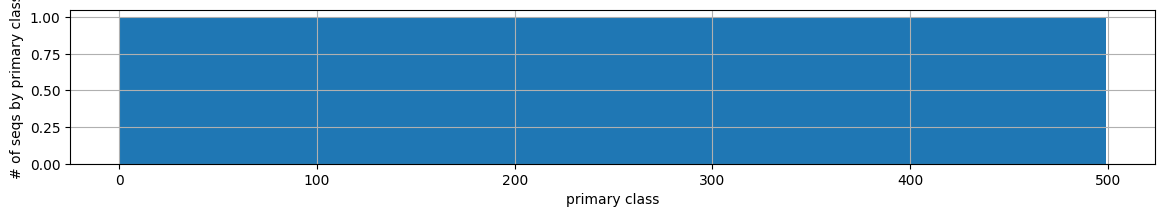

In [16]:
# histograma de frequencia das classes primárias - depende do ordenamento
from collections import Counter

counts = Counter(pClass)
# print(counts)
numero_mais_comum, frequencia_mais_comum = counts.most_common(1)[0]

# Exiba o número mais comum e sua frequência
print(f"The most common class is {numero_mais_comum} with {frequencia_mais_comum} copies")

plt.figure(figsize=(14,2))
plt.hist(pClass,P)
plt.grid()
plt.xlabel("primary class")
plt.ylabel("# of seqs by primary class")
plt.show()

In [17]:
class Model:
    def __init__(self, name = "", rep=2, nmbofclasses=0, nmbofclusters=0):

        self.name = name
        self.ListOfVarSites =[] #CBUC
        self.NmbOfClasses = nmbofclasses # CBUC
        self.CodeOfClass = [] # CBUC
        self.GroundTruth = [] # ANNOTATION
        self.NmbOfClusters =  nmbofclusters # CLOPE
        self.TheClusterOfClass = {} # CLOPE
        self.TheSpeciesOfCluster = {} # CLOPE + ANNOTATION
        self.repulsion = rep # CLOPE
        self.MinClusterAccuracy = 0 #  MODEL
        self.Accuracy = 0 # MODEL
        self.ConfusionMatrix =[] # MODEL
        self.Accession = [] # DATA - GVF
        self.CLOPE_repulsion = 0


In [18]:
model = Model("SARS2-spike2",nmbofclasses=P)
model.ListOfVarSites = Var_Sites #CBUC

# FASE 2 - ANÁLISE QUANTITATIVA

## 1. AGRUPAMENTO 
## 2. ANOTAÇÃO DAS CLASSES PRIMÁRIAS
## 3. CÁLCULO DA ACURÁCIA

# CLUSTERIZADOR NÃO SUPERVISIONADO - CLOPE

In [19]:
# classes e funções da clusterização com CLOPE

class Cluster:

    def __init__(self, history_count):
       # Histórico do número de transações em clusters
        self.history_count_transact = [0] * history_count
        # Área do histograma
        self.area = 0.0
        # A altura do histograma (no sentido de H=S/W). Esse valor não é calculado explicitamente em nenhum lugar.
         # Armazenado na classe para completar a descrição da classe e nada mais.
        self.height = 0.0
        # Largura do histograma (em termos de número de elementos)
        self.width = 0.0
        # Gradiente (no sentido de G=H/W). Esse valor não é calculado explicitamente em nenhum lugar.
        # Armazenado na classe para completar a descrição da classe e nada mais.
        self.gradient = 0.0
        # Número de transações
        self.count_transactions = 0
        # Histograma
        self.histogram = {}

    '''
    Adicione uma transação ao cluster. Iterar sobre todos os elementos do histograma, completar o histograma
     parâmetros de entrada:
     transação -- fatia com objetos (transação)
    '''
    def add_transaction(self, transaction):
        # Iterar por todos os elementos do histograma um por um e adicionar à coluna correspondente do histograma.
        # Se não há elemento em questão, então adicione uma nova coluna ao histograma
        for item in transaction:
            if not (item in self.histogram):
                self.histogram[item] = 1 # adiciona novo elelento ao histograma
            else:
                self.histogram[item] += 1 # incrementa o numero do elemento existente no histograma
        # Calculamos a área total do histograma no sentido de CLOPE (número de transações)
        self.area += float(len(transaction))
        # Calcular a largura do histograma (o número de objetos diferentes)
        self.width = float(len(self.histogram))
        # incrementa o número de transações no cluster
        self.count_transactions += 1

    '''
    Excluir transação do cluster. Passamos por todos os elementos do histograma, removemos todos os elementos da transação de
     histogramas

     parâmetros de entrada:
     transação -- fatia com objetos (transação)
     valores retornados:
     valor gradiente G (transação) # sem sentido

     Dentro da classe, não há rastreamento de quais transações são adicionadas, quais são excluídas, portanto, se em
     o processo de modificação excluirá uma transação que não foi adicionada ao cluster correspondente, o algoritmo
     vai dar resultado errado
     '''

    def remove_transaction(self, transaction):
            for item in transaction:
                if self.histogram[item] > 0: # new
                    self.histogram[item] -=1 # new
                if self.histogram[item] == 0:
                    del self.histogram[item]
            self.area -= float(len(transaction))
            self.width = float(len(self.histogram))
            self.count_transactions -= 1
            return # self.gradient # rare


class CLOPE:

    def __init__(self, print_step=1000, random_seed=None):

        if random_seed is not None:
            self.random_seed = random_seed
        else:
            self.random_seed = random.randint(0, 65536 + 1)

        # Lista de clusters
        self.clusters = {}  # CCluster
        # Números de clusters de ruído
        # Este objeto é necessário para não levar em consideração aqueles objetos que foram classificados como ruído
        self.noise_clusters = {}
        # Número de transações adicionadas
        self.count_transactions = 0
        # Número da iteração
        self.iteration = 0
        # inicializa dicionário: número da transação/número do cluster
        self.transaction = {}
        # Número máximo do cluster
        self.max_cluster_number = 0
        self.print_step = print_step

    '''
    A mudança de meta que a função objetivo receberá ao adicionar uma transação ao cluster clusterNumber é calculada.
     O cluster que entrega o valor máximo da função será o cluster desejado (ao qual se deve adicionar a transação)
     parâmetros de entrada:
     transação -- transação (lista de objetos)
     clusterNumber -- número do cluster cujo incremento está sendo calculado
     r -- repulsão no sentido de CLOPE
     valor retornado:
     Retorna o valor de alteração da função objetivo quando uma transação é adicionada ao cluster clusterNumber
    '''
    def get_delta(self, transaction, cluster_number, r):

        old_area = self.clusters[cluster_number].area
        old_width = self.clusters[cluster_number].width
        nmb_trans = self.clusters[cluster_number].count_transactions

        area = old_area + len(transaction) # calcula a área adicionando os objetos da transação
                                                                    # em análise
        # cálculo da largura do cluster
        width = old_width
        for item in transaction:
            if not (item in self.clusters[cluster_number].histogram): # histogram tem a lista de objetos no cluster
                width += 1

        # calcula delta (variação da função objetivo com a adição da transação ao cluster cluster_number)
        new_delta_value = 0
        if width != 0:
            new_delta_value = area * (nmb_trans + 1) / (width ** r)

        # calcula o valor de delta sem a transação
        if old_width != 0:
            old_delta_value = old_area * nmb_trans / (old_width ** r)
        else:
            old_delta_value = 0

        return new_delta_value - old_delta_value

    '''
    Função de remoção de ruído. Todos os clusters maiores que o limite permanecem ativos.
     parâmetros de entrada:
     limite -- nível de ruído do cluster
    '''
    def noise_reduction(self, limit):
        # Remova todos os clusters vazios e barulhentos
        new_clusters = {}
        for item in self.clusters:
            if self.clusters[item].count_transactions > limit:# se o cluster é maior que o limite permanece na lista de clusters ativos
                new_clusters[item] = self.clusters[item]
            else: # clusters pequenos são considerados ruidosos e saem da lista de clusters ativo -
                  # passam para alista de clusters com ruido
                self.noise_clusters[item] = True
        self.clusters = new_clusters

    '''
    Cálculo da função objetivo para todos os clusters já formados
     Usado ao modificar clusters ou inicializá-los
     parâmetros de entrada:
     r -- número real denotando repulsão de cluster no sentido de CLOPE
     valor retornado:
     Retorna o valor da função objetivo
    '''
    def get_goal_function(self, r):
        measure = 0.0
        # Percorremos todos os clusters e para cada um calculamos seu peso.
        # Todos os pesos são resumidos em uma métrica comum
        for item in self.clusters:
            if item.width == 0:
                # print "test"
                pass
            else:
                # # Tentando encontrar uma métrica diferente
                # measure += (r ** 2 * math.log(item.Area ** (1 / r) / item.Width) ** 2) *
                # item.CountTransactions / self.CountTransactions
                measure += item.area / (item.width ** r) * item.count_transactions
        return measure / self.count_transactions

    '''
     Adicionando uma nova transação
     Estamos tentando redistribuir a transação com o número de id em outra classe para que a função de custo tenha
     valor máximo
     parâmetros de entrada:
     transação -- transação (fatia com objetos)
     id -- número da transação
     repulsão -- número real, denotando repulsão de clusters no sentido de CLOPE
     isSaveHistory -- sinalizador definido se for necessário registrar o histórico do número de transações
     parâmetro retornado:
     Retorna o número do cluster ao qual a transação atual foi adicionada
    '''
    def move_transaction(self, transaction, id, repulsion=2, max_count_clusters=None):

        r = repulsion
        max_value = None
        max_value_index = None
        self.count_transactions += 1

        # Estamos procurando um cluster no qual o valor máximo da mudança na função objetivo seja alcançado
        for cluster_number in self.clusters:
            delta = self.get_delta(transaction, cluster_number, r)
            if (delta > 0 or max_count_clusters is not None) and (max_value is None or delta > max_value):
                max_value_index = cluster_number
                max_value = delta

        # Adicione uma transação a um novo cluster e veja o resultado - registre o cluster com maior valor
        if max_count_clusters is None or len(self.clusters) < max_count_clusters:
            self.clusters[self.max_cluster_number] = Cluster(self.count_transactions)
            if max_value is None or self.get_delta(transaction, self.max_cluster_number, r) > max_value:
                max_value_index = self.max_cluster_number
                self.max_cluster_number += 1
            else:
                del self.clusters[self.max_cluster_number]

        # Lembramos em qual cluster está a transação atual
        self.transaction[id] = max_value_index

        #Adicionando uma transação ao cluster necessário
        self.clusters[max_value_index].add_transaction(transaction)

        return max_value_index

    '''
    Cálculo de limiar de ruído adaptativo. O limite é limpo em relação à mediana dos tamanhos de cluster (incluindo
     transações). Pegue 3/4 da mediana
    '''
    def get_noise_limit(self, percentile=0.75):
        size_clusters = []
        for item in self.clusters:
            size_clusters.append(self.clusters[item].count_transactions)
        sorted(size_clusters)
        median_element = int(len(size_clusters) * percentile) + 1
        if len(size_clusters) < 5:
            limit = 10
        else:
            limit = size_clusters[median_element]
        return limit

    '''
    Inicialização do cluster
    parâmetros de entrada:
    dados -- fatia com transações
    isPrint -- se deve imprimir informações de progresso (0 -- não é necessário, se > 0 -- imprimir a cada isPrint time)
    repulsão -- número real, denotando repulsão de clusters no sentido de CLOPE
    isSaveHistory -- sinalizador definido se for necessário registrar o histórico do número de transações
    isNoiseReduction -- redução de ruído (limiar corresponde ao número de elementos no cluster no qual ele é destruído).
                        Se isNoiseReduction == -1, então o limite é selecionado de forma adaptativa (tudo que for maior que a mediana
                        restos)
    '''
    def init_clusters(self, data, repulsion=2, is_noise_reduction=-1, noise_median_threshold=0.75,
                      max_count_clusters=None):
        index = 0
        keys = sorted(data.keys())
        np.random.seed(self.random_seed)
        np.random.shuffle(keys)
        for item in keys:
            self.move_transaction(data[item], item, repulsion, max_count_clusters)
            index += 1
            if self.print_step > 0 and index % self.print_step == 0:
                print("ITERAÇÃO: ", self.iteration, ". NÚMERO DA ETAPA", index, ". NÚMERO DE CLUSTERS: ", len(self.clusters))
                pass

        # Obtendo o limite de ruído ideal
        if is_noise_reduction < 0:
            is_noise_reduction = self.get_noise_limit(noise_median_threshold)
        # Remova todos os clusters de ruído
        # (após a inicialização, não há classes vazias, portanto, o sinal é estritamente maior)
        if is_noise_reduction > 0:
            self.noise_reduction(is_noise_reduction)

        self.iteration = 1

    '''
    Execução do algoritmo. Dando o próximo passo
    parâmetros de entrada:
    dados -- fatia com transações
    isPrint -- se deve imprimir informações de progresso (0 -- não é necessário, se > 0 -- imprimir a cada isPrint time)
    repulsão -- número real, denotando repulsão de clusters no sentido de CLOPE
    isSaveHistory -- sinalizador definido se for necessário registrar o histórico do número de transações
    isNoiseReduction -- redução de ruído (limiar corresponde ao número de elementos no cluster no qual ele é destruído).
                        Se isNoiseReduction == -1, então o limite é selecionado de forma adaptativa (tudo que for maior que a mediana
                        restos)
    parâmetro retornado:
    Retorna o número de operações para transferir uma transação de cluster para cluster
    '''
    def next_step(self, data, repulsion=2, is_noise_reduction=-1, noise_median_threshold=0.75, max_count_clusters=None):

        # Remova todos os clusters vazios (ou ruído, se isNoiseReduction > 0)
        if is_noise_reduction < 0:
            is_noise_reduction = self.get_noise_limit(noise_median_threshold)
        self.noise_reduction(is_noise_reduction)

        index = 0
        # O número de transações que foram transferidas
        moves = 0
        keys = sorted(data.keys())
        np.random.seed(self.random_seed)
        np.random.shuffle(keys)
        for id in keys:
            # Nós olhamos onde esta transação está agora
            cluster_number = self.transaction[id]
            transaction = data[id]
            # Se a transação pertencer a um cluster de ruído, não tentaremos alterá-la
#             if cluster_number in self.noise_clusters:
#                 eps += 0
#             else:
            # Recuperar uma transação do cluster atual
            self.clusters[cluster_number].remove_transaction(transaction)
            # Consideramos a transação como recém-chegada e a adicionamos ao cluster onde o valor do destino
            # máximiza a função custo
            moves += int(self.move_transaction(transaction, id, repulsion, max_count_clusters) != cluster_number)

            index += 1
            if self.print_step is not None and self.print_step > 0 and index % self.print_step == 0:
#                 print("Итерация: ", self.iteration, ". Номер шага", index, ". Число кластеров: ", len(self.clusters))
#                 print("ITERAÇÃO: ", self.iteration, ". NÚMERO DA ETAPA", index, ". NÚMERO DE CLUSTERS: ", len(self.clusters))
                pass

        self.iteration += 1

        self.noise_reduction(is_noise_reduction)

        return moves

    '''
    Desenhamos um gráfico mostrando o número de transações em diferentes classes TO DO !!!!

    '''
    def print_history_count(self, repulsion, seed):
        pass

In [20]:
# funções que constroem a matriz de confusão e calculam o erro usando o ground truth

def CompareResultAndAnnotation(accession, annot, clope, verbose=False):

    # pegamos a lista de genotipos anotados distintos <= numero de sequencias no data set de treinamento
    species=list(set(annot)) # colunas
#     if verbose:
#         print("list of genotypes in dataset:\n",species)# numeramos os genótipos segundo a ordem na lista

    nspecies = len(species)

    species_nmb={} # dict annotacao da especie -> numero ordinal da especie anotada

    # atribuindo um consecutivo a cada genotipo
    ctr=0
    for sp in species:
        species_nmb[sp]=ctr
        ctr+=1

    # calculamos o numero de transacoes de cada espécie anotada (a multiplicidade delas)
    colsum = np.zeros(nspecies,dtype=int)
    for sp in annot:
        colsum[species_nmb[sp]]+=1
#     if verbose:
#         print("number of strain by genotype (colsum) \n",colsum)

    # inicializa a matriz de confusão
    K = clope.max_cluster_number
    conf_matrix = np.zeros((K,nspecies),dtype=int)
    # varre dict transaction {trans_id:cluster}
    for trans_id in range(len(clope.transaction)):
        cluster = clope.transaction[trans_id]
        conf_matrix[cluster,species_nmb[annot[trans_id]]]+=1 # OK

    # attributing most probable genotype to each cluster
    annotation={}
    for cluster in range(K):
        if np.sum(conf_matrix[cluster])>0:
            # anotando cada cluster com a especie mais provável
            sort = -np.sort(-conf_matrix[cluster]) # ORDENANDO DE MAIOR A MENOR
            if sort[1]==sort[0]: # tem mais de um máximo
                annotation[accession[cluster]]="MULTIPLE SPECIES" # "UNKNOWN" # TWO OR MORE SPECIS WITH EQUAL FREQUENCY
            else:
                annotation[accession[cluster]]=species[np.argmax(conf_matrix[cluster])]
        else:
            annotation[accession[cluster]]="EMPTY CLUSTER" # CLUSTER VAZIO - RARIDADE MAS NÃO IMPOSSIVEL

    return np.array(conf_matrix), annotation

def GetClusteringError(confmat):

    # cálculo da métrica de erro relativo por cluster : numero de seqs - max
    accuracy=[]
    n = np.sum(confmat)
    tot_error=0
    for cluster in range(confmat.shape[0]):
        aux0 = np.sum(confmat[cluster]) # number of species in this cluster
        aux = aux0 - np.max(confmat[cluster]) # number of species outside the most frequented cluster
        tot_error += aux
        if aux0 > 0:
            accuracy.append(1 - aux/aux0)
        else:
            accuracy.append(0) # EMPTY CLUSTER CASE ------------->

    return np.array(accuracy), 1-tot_error/n


# acessando à anotação de cada classe primária

In [27]:

# Caminho do arquivo de anotações
arquivo_anotacoes = '/home/m_souza/tcc/dataset/dataset_agua/anotacoes.txt'

# Dicionário para armazenar as anotações
annot = {}

# Ler o arquivo de anotações
with open(arquivo_anotacoes, 'r') as anotacoes_file:
    for linha in anotacoes_file:
        # Dividir a linha usando a vírgula como separador
        partes = linha.strip().split(',') # primeira parte ID longo terminando en ACCN,
                                            # segunda parte o tipo Pangolin

        # Verificar se a linha tem o formato correto
        if len(partes) == 2:
            cabecalho, anotacao = partes
            annot[cabecalho.split("|")[1]] = anotacao # new 05.10.2023
        else:
            print(f"A linha '{linha}' não possui o formato esperado.")

# Exibir o dicionário de anotações
nAnnotSeq = len(annot)
if nAnnotSeq!=Nseq:
    print("PROBLEM: THE NUMBER OF FILTERED SEQUENCES AND ANNOTATED SEQUENCES DOES NOT MATCH ...CALL DIEGO!")
else:
    print("we read ",nAnnotSeq," annotated sequence accessions\n", annot) # {accesion: Pangolin genotype}

# check - all inoput sequence must be annotated


we read  500  annotated sequence accessions
 {'OM056186': 'B.1.1.529', 'OM058922': 'B.1.1.529', 'OM059019': 'B.1.1.529', 'OM059033': 'B.1.1.529', 'OM059246': 'B.1.1.529', 'OM065541': 'B.1.1.529', 'OM065547': 'B.1.1.529', 'OM065569': 'B.1.1.529', 'OM065570': 'B.1.1.529', 'OM065572': 'B.1.1.529', 'OM065582': 'B.1.1.529', 'OM065584': 'B.1.1.529', 'OM065586': 'B.1.1.529', 'OM065603': 'B.1.1.529', 'OM065661': 'B.1.1.529', 'OM065662': 'B.1.1.529', 'OM065665': 'B.1.1.529', 'OM065677': 'B.1.1.529', 'OM065684': 'B.1.1.529', 'OM065682': 'B.1.1.529', 'OM065685': 'B.1.1.529', 'OM065686': 'B.1.1.529', 'OM065688': 'B.1.1.529', 'OM065691': 'B.1.1.529', 'OM065696': 'B.1.1.529', 'OM065709': 'B.1.1.529', 'OM065712': 'B.1.1.529', 'OM065714': 'B.1.1.529', 'OM036675': 'B.1.1.529', 'OM036870': 'B.1.1.529', 'OM036966': 'B.1.1.529', 'OM038376': 'B.1.1.529', 'OM116753': 'B.1.1.529', 'OM133912': 'B.1.1.529', 'OM117210': 'B.1.1.529', 'OM117387': 'B.1.1.529', 'OM135128': 'B.1.1.529', 'OM135237': 'B.1.1.529', 'OM1

In [28]:
# pegando as espécies virais anotadas
species=list(set(annot.values()))
Nspecies = len(species)
print("we found ",Nspecies," annotated genotypes\n", species)

we found  5  annotated genotypes
 ['P.1', 'B.1.617.2', 'B.1.1.7', 'B.1.351', 'B.1.1.529']


In [29]:
def get_accession(new_accession, transactions):
    for j in range(len(transactions)):
#         print(new_accession,"=?",transactions[j][0].replace("/",""))
        if new_accession in transactions[j][0].replace("/",""):
            return transactions[j][0]
    return "unknown"

# random iterations:
## varying repulsion in a given search interval
## for each repulsion value: 
### > finding clusters with different sorting of input
### > calculating minimum accuracies of clusters to control achievement of quality criteria
### > finishing random iterations  it check if repulsion satisfies the quality threshold: 
### >> if OK exit the repulsion loop and build model data

In [30]:
# MAIN -----------------------------------------------------

# pegando a lista de accession
Acc = gvf['accession']
# tirando barras para match com annot
Accession0=[]
for acc in Acc:
    Accession0.append(acc.replace("/",""))
# print(Accession0[:3])

# pegando o groundthruth da anotação
GroundTruth0 = list(annot.values())
#GroundTruth0[:3]

# pegando os vetores de chars dos códigos das classes primárias como transações
InputData0 = pvec
nmb_trans=len(pvec)

nmb_annot=len(GroundTruth0)
print('check: number of transactions = annotations: ',nmb_trans,'=',nmb_annot)

if nmb_trans!=nmb_annot:
    print("DATASET NOT FULLY OR WRONGLY ANNOTATED .....\nRESULTS MAY BE CONFUSING....")

noiseLimit = 0.0 # dummy

nRandIterations = 50 # equivalent to bootstrap
ClusterAccuracyThres = 0.99 #1.00

print("Looking for optimal repulsion with ",nRandIterations,\
      "random iterations and threshold of minimum cluster accuracy of ",ClusterAccuracyThres)

optimum=False
minRep=5
maxRep=50
stpRep=5

trans_len=len(InputData0[0])

best_repulsion = -1
best_accuracy = 0
K = nmb_trans

for repulsion in range(minRep,maxRep,stpRep): #>= 11 da 1005 acc de clusters com 200 iteracoes randomicas

    print("\n>>>> repulsion", repulsion)

    cluster_accuracy=[]
    Accuracy=[]

    best_K = nmb_trans

    codes = InputData0
    GT = GroundTruth0

    for i in range(nRandIterations):

        seed = None #150 <<<<<<<<<<<<<<<<<<<<<<<< ORDENAÇÂO ALEATORIA
        np.random.seed(seed)

    # not needed because clope shuffle input data every it is called << NEW 07.10.2023
    #     InputData=InputData0.copy()
#         list_zipped = list(zip(Accession0,InputData0,GroundTruth0))
#         np.random.shuffle(list_zipped)
#         Accession, InputData, GroundTruth = zip(*list_zipped) #unzipping

        Accession, InputData, GroundTruth = Accession0, InputData0, GroundTruth0

        # print('first transactions:\n',InputData[:3])
        # print('first annotations:\n',GroundTruth[:3])

        Data = {} # usamos um dicionario para os dados com as features indexadas por posição

        for trans_nmb in range(0, len(InputData)):
            Data[trans_nmb] = [''] * trans_len # inicializa a transação efetiva
            fst=0 # for SARS2
            for index in range(fst, len(InputData[trans_nmb])):
                # adicionando a posição (coluna) da feature se não for missing & counting missings
                if InputData[trans_nmb][index] != '?':
                    Data[trans_nmb][index] = str(index) + ":"+InputData[trans_nmb][index].replace(" ","")  # add feature position

        clope = CLOPE(print_step=1000, random_seed=seed)
        # Dados iniciais

        # Inicializamos o algoritmo
        clope.init_clusters(Data, repulsion, noiseLimit)

        # Nós iteramos
        ctr=0
        while clope.next_step(Data, repulsion, noiseLimit ) > 0:
            ctr+=1
            clope.print_history_count(repulsion, seed)

        print("RANDOM ITERATION ",i+1," -> clope iterations: ",ctr)

#         print("CLOPE number of clusters ",clope.max_cluster_number)
        # print(clope.transaction.values())
        # print("annot",list(GroundTruth))

        # cálculo do erro da classificação

        confmat, map_species2cluster = CompareResultAndAnnotation(Accession, GroundTruth, clope,True)
#         print("non-empty cluster number ",len(confmat))

#         print("matriz de confusão - quantas seqs pertencem a cada genótipo (colunas) em cada cluster (linha):\n",confmat)
#         print(map_species_cluster)

        # cálculo da métrica de erro por cluster : numero de seqs - max
        accuracy_lst, tot_accuracy = GetClusteringError(confmat)

        cluster_accuracy.append(accuracy_lst)
        Accuracy.append(tot_accuracy)

#         print("erro relativo por cluster: \n",100*acc_lst," %")
#         print("acurácia total",100*tot_acc," %")

        # condition to choose the best clustering during iterations
        if (np.min(cluster_accuracy[-1]) > best_accuracy) and (len(confmat) < best_K):
            # A CONDIÇÃO ACIMA BUSCA A COMBINAÇÃO COM MENOR CONFUSÃO (MAIOR ACURACIA)
            # E MENOR NUMERO DE CLUSTERS !!!!!!
            best_clusters_accuracy = cluster_accuracy[-1]
            best_accuracy = np.min(best_clusters_accuracy) # or mean
            best_K = len(confmat)
            K = best_K
            best_confmat = confmat
            best_annotation = map_species2cluster
            map_class2cluster = clope.transaction
            codes = InputData
            GT = GroundTruth
            best_accession = Accession
            best_repulsion = repulsion
            print(">>>>>>>>>>>>>>>> best found with ",best_K," clusters. accuracy = ",best_accuracy)

        del clope

        # calculo a media e desvio padrão da minima acuracia nos clusters em cada iteração
#         min_lst=[]
#         for i in range(len(cluster_accuracy)):
#             min_lst.append(np.min(cluster_accuracy[i]))
#         #     print(np.min(cluster_acc[i]))
#         mean_min_cluster_accuracy=np.mean(min_lst)
#         std_min_cluster_accuracy=np.std(min_lst)
#         min_min_cluster_accuracy=np.min(min_lst)
    #     print("mean minimum cluster accuracy ",mean_min_cluster_acc," standard deviation ",std_min_cluster_acc)
    #     print("minimum minimum cluster accuracy ",min_min_cluster_acc,"estimated minimum minimum cluster accuracy ", \
    #           mean_min_cluster_acc-2*std_min_cluster_acc)

    # controle de optimalidade
    # AQUI SE DEFINE QUÃO EXIGENTE É O ESTUDO, SE PERMITE ALGUM NIVEL DE CONFUSÃO OU NÃO
    # SE  ClusterAccuracyThres = 1 => É PORQUE NÃO HOUVE NENHUMA MSITURA DE ESPECIES NOS CLUSTERS, OU SEJA
    # CADA CLUSTER CONTINHA UM UNICO TIPO DE ESPECIE ANOTADA
    if best_accuracy >= ClusterAccuracyThres: # NEW 08.10.2023
        print("satisfied optimality criteria")
        optimum=True
        break # saimos do loop aumentando repulsion



check: number of transactions = annotations:  500 = 500
Looking for optimal repulsion with  50 random iterations and threshold of minimum cluster accuracy of  0.99

>>>> repulsion 5
RANDOM ITERATION  1  -> clope iterations:  11
>>>>>>>>>>>>>>>> best found with  8  clusters. accuracy =  0.2070484581497798
RANDOM ITERATION  2  -> clope iterations:  7
RANDOM ITERATION  3  -> clope iterations:  5
>>>>>>>>>>>>>>>> best found with  7  clusters. accuracy =  0.24782608695652175
RANDOM ITERATION  4  -> clope iterations:  5
RANDOM ITERATION  5  -> clope iterations:  4
RANDOM ITERATION  6  -> clope iterations:  5
RANDOM ITERATION  7  -> clope iterations:  5
RANDOM ITERATION  8  -> clope iterations:  4
RANDOM ITERATION  9  -> clope iterations:  6
RANDOM ITERATION  10  -> clope iterations:  5
RANDOM ITERATION  11  -> clope iterations:  4
RANDOM ITERATION  12  -> clope iterations:  5
RANDOM ITERATION  13  -> clope iterations:  5
RANDOM ITERATION  14  -> clope iterations:  3
RANDOM ITERATION  15  -> 

In [31]:
if optimum:
    print("optimum criterium found for repulsion = ",best_repulsion," accuracy = ",best_accuracy)
else:
    print("optimum not found for repulsion in the interval [",minRep,",",maxRep,"]")

model.NmbOfClusters = K
model.Accuracy = np.mean(best_clusters_accuracy) # mean
model.MinClusterAccuracy = best_accuracy # MODEL
model.ConfusionMatrix = best_confmat # MODEL
model.CodeOfClass = codes # origin CBUC but shuffled by AGUA
model.GroundTruth = GT # ANNOTATION
model.TheClusterOfClass = map_class2cluster # CLOPE
model.TheSpeciesOfCluster = list(best_annotation.values()) # CLOPE + ANNOTATION
model.CLOPE_repulsion = best_repulsion # MODEL
baccession=[]
for acc in best_accession:
    baccession.append(get_accession(acc,t))
model.Accession=baccession # CBUC but shuffled by AGUA

print("Mean accuracy of the model ",np.mean(model.Accuracy),\
      " standard deviation of accuracy ",np.std(model.Accuracy))
print("Number of Classes :",model.NmbOfClasses)
#     print("CodesOf Classes :\n",model.CodeOfClass)
#     print("Annotation of Classes :\n",model.GroundTruth)
print("Number of clusters",model.NmbOfClusters)
df_ConfMat_SpeciesByClusters = pd.DataFrame(zip(model.ConfusionMatrix,model.TheSpeciesOfCluster))
print("Confusion matrix\n",df_ConfMat_SpeciesByClusters)
for i in range(len(df_ConfMat_SpeciesByClusters[1])):
    if df_ConfMat_SpeciesByClusters[1][i]=="MULTIPLE SPECIES":
        print(i,df_ConfMat_SpeciesByClusters[0][i],\
              "nseqs (",np.sum(df_ConfMat_SpeciesByClusters[0][i]),")")

optimum criterium found for repulsion =  25  accuracy =  1.0
Mean accuracy of the model  1.0  standard deviation of accuracy  0.0
Number of Classes : 500
Number of clusters 63
Confusion matrix
                    0          1
0   [0, 0, 0, 35, 0]    B.1.351
1   [29, 0, 0, 0, 0]        P.1
2   [0, 0, 0, 0, 33]  B.1.1.529
3   [0, 32, 0, 0, 0]  B.1.617.2
4   [0, 0, 33, 0, 0]    B.1.1.7
..               ...        ...
58   [1, 0, 0, 0, 0]        P.1
59   [0, 0, 0, 1, 0]    B.1.351
60   [0, 1, 0, 0, 0]  B.1.617.2
61   [0, 0, 1, 0, 0]    B.1.1.7
62   [1, 0, 0, 0, 0]        P.1

[63 rows x 2 columns]


# FASE 3 - ANÁLISE QUALITATIVA

In [32]:
# calculating distances between pairs of IDs -> put in categorical distance matrix

def categoricaldist(u,v,var,mode=0): # calcula a distancia entre 2 vetores categóricos:
    # numero de entradas distintas / total de entradas
    dist=0
    for i in range(len(u)):
        if u[i]!=v[i]:
            if mode==0:
                dist+=1/var[i] # weighted -> INVERSAMENTE PROPORCIONAL À VARIABILIDADE DO SITE
            else:
                dist+=1 # SEM CONSIDERAR A VARIABILIDADE DO SITE

    return dist/len(u)



In [33]:
# -------------------------------------------------------------------

print("FASE2 - CÁLCULO DA MATRIZ DE DISTÂNCIAS ENTRE PARES DE CLASSES PRIMÁRIAS ")

fvec=model.CodeOfClass

start=time.time()

cat_distmatrix=[]
for i in range(P-1):
    cat_distmatrix.append([])
    for j in range(i+1,P):
#         dotdistmatrix[-1].append(np.dot(pvec[i],pvec[j]))
        cat_distmatrix[-1].append(categoricaldist(fvec[i],fvec[j],var,1))
        # lçast prm above: calling in mode=0 sem pesos, calling in mode=1 com pesos
#         print(i,j,np.dot(pvec[i],pvec[j]))

# check
# for distvec in cat_distmatrix:
#     print(distvec)

# gerando matriz de distancias simetrica

# nota: os vetores dists , fst e scd estão alinhados, ou seja dists[k] é a distância entre a classe fst[k] e a scd[k] !!!

DistMat=np.zeros((P,P),dtype=float)
labels=[]
# fst & scd são o par de indexadores de cada distância (as classes primárias que são comparadas)
fst=[]
scd=[]
for i in range(P-1):
    labels.append("class"+str(i)+" annot "+model.GroundTruth[i]+ " cluster "+\
                  str(model.TheClusterOfClass[i]))
                #+" pred "+model.TheSpeciesOfCluster[model.TheClusterOfClass[i]])
    for j in range(i+1,P):
        fst.append(i)
        scd.append(j)
        DistMat[i][j]=cat_distmatrix[i][j-i-1]
        DistMat[j][i]=DistMat[i][j] # building a symmetric matrix

# labeling last row
labels.append("class"+str(P-1)+" annot "+model.GroundTruth[P-1]+ " cluster "+\
              str(model.TheClusterOfClass[P-1]))
                #+ " pred "+model.TheSpeciesOfCluster[model.TheClusterOfClass[P-1]])

print("matriz de distâncias\n", DistMat)

np.savetxt(model.name+'_dist_mat.txt', DistMat)

dists = squareform(DistMat) # saida para a construcao de arvores com dendogram
print("vetor de distancias\n", dists)

print(f"tempo:{time.time()-start} segundos")


FASE2 - CÁLCULO DA MATRIZ DE DISTÂNCIAS ENTRE PARES DE CLASSES PRIMÁRIAS 
matriz de distâncias
 [[0.         0.01398601 0.01048951 ... 0.06818182 0.06293706 0.06468531]
 [0.01398601 0.         0.01048951 ... 0.06818182 0.06293706 0.06468531]
 [0.01048951 0.01048951 0.         ... 0.05769231 0.05244755 0.0541958 ]
 ...
 [0.06818182 0.06818182 0.05769231 ... 0.         0.00874126 0.00699301]
 [0.06293706 0.06293706 0.05244755 ... 0.00874126 0.         0.00524476]
 [0.06468531 0.06468531 0.0541958  ... 0.00699301 0.00524476 0.        ]]
vetor de distancias
 [0.01398601 0.01048951 0.01223776 ... 0.00874126 0.00699301 0.00524476]
tempo:13.413110733032227 segundos


In [34]:
#atualizando labels com a especie predita
print(model.TheClusterOfClass)
target = 4
for pclass in model.TheClusterOfClass.keys():
    if model.TheClusterOfClass[pclass]==target:
        print("classes in cluster ",target," = ",pclass," annot ",model.GroundTruth[pclass])

{445: 17, 369: 14, 82: 2, 259: 3, 182: 4, 245: 3, 437: 0, 488: 17, 469: 0, 331: 14, 244: 3, 494: 0, 378: 1, 356: 33, 370: 50, 267: 3, 285: 25, 397: 1, 280: 5, 321: 1, 130: 4, 410: 0, 422: 0, 414: 0, 365: 38, 425: 6, 474: 17, 419: 6, 140: 15, 347: 38, 440: 17, 218: 3, 335: 1, 459: 0, 460: 7, 390: 1, 9: 2, 407: 0, 145: 23, 95: 2, 326: 1, 29: 8, 246: 3, 97: 2, 48: 9, 200: 51, 444: 43, 71: 2, 17: 28, 236: 25, 227: 3, 103: 4, 47: 10, 37: 11, 258: 51, 43: 12, 262: 34, 447: 17, 269: 3, 401: 0, 84: 13, 312: 1, 40: 2, 166: 27, 416: 0, 90: 2, 290: 16, 178: 23, 221: 3, 239: 25, 383: 32, 277: 34, 105: 4, 439: 43, 454: 17, 223: 25, 452: 17, 298: 25, 109: 23, 375: 1, 496: 17, 156: 27, 152: 15, 113: 23, 21: 28, 177: 15, 196: 27, 243: 34, 346: 1, 374: 1, 217: 3, 35: 11, 428: 7, 313: 14, 489: 6, 238: 3, 225: 3, 434: 17, 406: 0, 376: 1, 364: 1, 322: 1, 299: 60, 237: 25, 232: 48, 272: 16, 181: 53, 36: 19, 483: 6, 339: 1, 402: 49, 27: 28, 260: 3, 379: 32, 206: 3, 80: 11, 293: 16, 149: 27, 256: 34, 371: 1,

# visualizando árvore filogenética

# linkage methods
The following are methods for calculating the distance between the newly formed cluster  and each .

1. method=’single’  also known as the Nearest Point Algorithm.

2. method=’complete’  also known by the Farthest Point Algorithm or Voor Hees Algorithm.

3. method=’average’ also called the UPGMA algorithm.

4. method=’weighted’ also called WPGMA.

5. method=’centroid’  also known as the UPGMC algorithm.

6. method=’median’  also known as the WPGMC algorithm.

7. method=’ward’ also known as the incremental algorithm.



In [35]:
# methods=['single', 'complete','average','weighted','centroid','median','ward']
# methodknownas=['NearestPoint', 'FarthestPoint','UPGMA','WPGMA','UPGMC','WPGMC','Incremental']
methods=['ward','weighted']
methodknownas=['Incremental','WPGMA']
nmeth=len(methods)

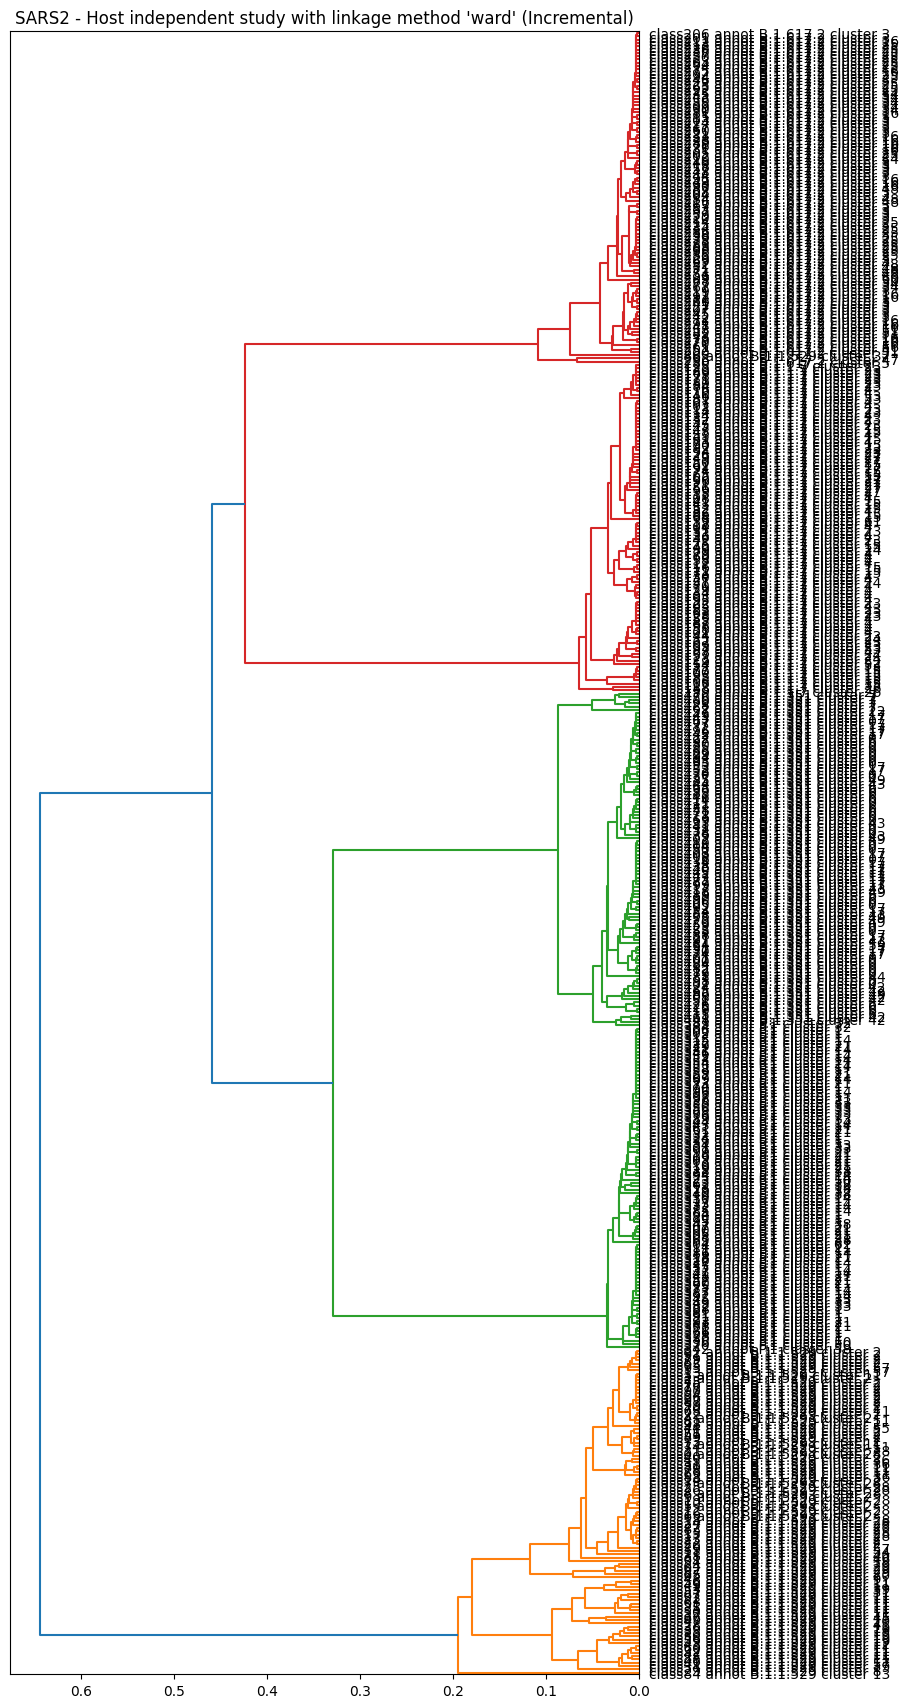

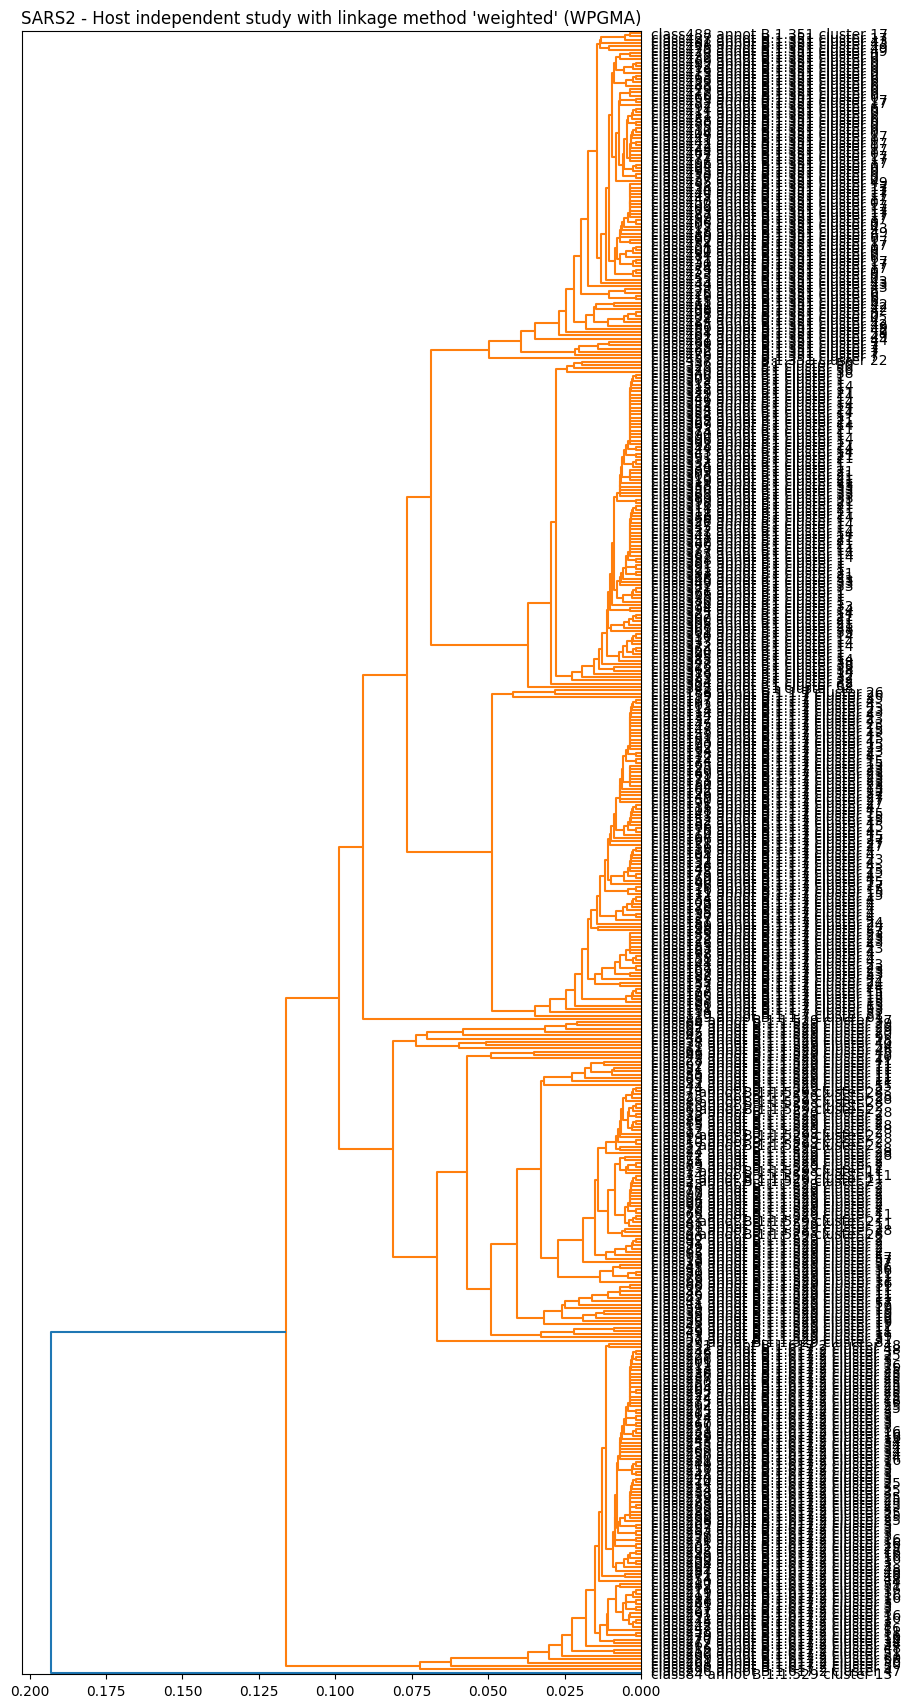

In [36]:
# construindo arvores com distintos métodos de linkagem da scipy.cluster.hierarch.linkage
ctr=0
for meth in methods:
    linkage_matrix = linkage(dists, meth)
    fig, ax = plt.subplots(1, 1, figsize=(10, 18))
    fig.set_size_inches(10, 18, forward=True)
    dn= dendrogram(linkage_matrix, ax=ax, labels=labels, show_leaf_counts=True, show_contracted=True, orientation='left',leaf_font_size=10)
    plt.title("SARS2 - Host independent study with linkage method '"+meth+"' ("+methodknownas[ctr]+")")
#     plt.tight_layout()
    #or:
    plt.tight_layout(pad=4)
    plt.show()
    fig.savefig('tree_'+methodknownas[ctr]+'.png', dpi=fig.dpi)
    ctr+=1

In [37]:
def print_model(model,n):
    print("name:", model.name)
    print("ListOfVarSites:\n",model.ListOfVarSites)
    print("NmbOfClasses:",model.NmbOfClasses)
    print("CodeOfClass[:",n,"]:\n",model.CodeOfClass[:n])
    print("GroundTruth[:",n,"]:\n",model.GroundTruth[:n])
    print("Accession[:",n,"]:\n",model.Accession[:n])
    print("repulsion:",model.repulsion)
    print("NmbOfClusters:",model.NmbOfClusters)
    print("TheSpeciesOfCluster:\n",model.TheSpeciesOfCluster)
    print("MinClusterAcc:",model.MinClusterAccuracy)
    print("Accuracy:",model.Accuracy)
    print("CLOPE repulsion parameter:",model.CLOPE_repulsion)
    print("ConfusionMatrix:\n",model.ConfusionMatrix)
    print("TheClusterOfClass:\n",model.TheClusterOfClass)


In [38]:
print_model(model,2)

name: SARS2-spike2
ListOfVarSites:
 [4, 5, 6, 8, 10, 11, 12, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 35, 37, 44, 48, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 177, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 202, 205, 208, 209, 210, 211, 214, 215, 216, 220, 221, 224, 225, 226, 233, 234, 235, 236, 239, 240, 241, 242, 243, 244, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 29

# CREATING THE GENE VARIANT FILE


In [39]:
# creating and saving the final GVF file

GVF=pd.DataFrame(model.CodeOfClass)
col_rename_dict = {i:j for i,j in zip(GVF.columns,model.ListOfVarSites)}
GVF.rename(columns=col_rename_dict, inplace=True)

GVF['accession']=model.Accession
GVF['ground_truth']=model.GroundTruth

GVF

GVF.to_csv(model.name+'.gvf')

In [40]:
print(GVF.columns)

Index([             4,              5,              6,              8,
                   10,             11,             12,             15,
                   17,             18,
       ...
                 1236,           1237,           1242,           1246,
                 1247,           1262,           1263,           1266,
          'accession', 'ground_truth'],
      dtype='object', length=574)


In [41]:
# saving and loading the  model

# Save the file
model_filename="model."+model.name+".obj"
dill.dump(model, file = open(model_filename, "wb"))

# Reload the file
loaded_model = dill.load(open(model_filename, "rb"))
print_model(loaded_model,2)

name: SARS2-spike2
ListOfVarSites:
 [4, 5, 6, 8, 10, 11, 12, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 35, 37, 44, 48, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 177, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 202, 205, 208, 209, 210, 211, 214, 215, 216, 220, 221, 224, 225, 226, 233, 234, 235, 236, 239, 240, 241, 242, 243, 244, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 29

In [ ]:
# READY TO USE IN THE PRODUCTION PHASE - 23.10.2022